# Big Mart Sales Prediction with XGBoost

This project aims to predict Big Mart sales using an XGBoost Regressor. The process involves:

1.  **Data Exploration and Preprocessing:** Loading "Big Mart.csv", performing EDA, identifying feature types, and handling missing 'Item_Weight' (mean imputation) and 'Outlet_Size' (mode imputation). Visualizations aided understanding.

2.  **Feature Engineering:** Applying Label Encoding to convert categorical features into numerical representations for the model.

3.  **Data Splitting:** Dividing the data into features (X) and the target ('Item_Outlet_Sales' - Y), followed by an 80/20 train-test split with a fixed random state.

4.  **Model Training:** Initializing and training an XGBoost Regressor with specific hyperparameters and early stopping based on validation RMSE to prevent overfitting.

5.  **Final Evaluation:** Assessing the trained model's performance on both training and testing sets using the R-squared ($R^2$) metric.

## Importing Required Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn import metrics

## Data Collection and Inspection

In [2]:
big_mart_data = pd.read_csv("Big_Mart.csv")
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
big_mart_data.shape

(8523, 12)

In [4]:
# getting information of the dataframe
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Data Preprocessing

In [5]:
# Categorical columns
cat_col = [col for col in big_mart_data.columns if big_mart_data[col].dtype == 'object']
print('Categorical columns :',cat_col)

Categorical columns : ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [6]:
# Numerical columns
num_col = [col for col in big_mart_data.columns if big_mart_data[col].dtype != 'object']
print('Numerical columns :',num_col)

Numerical columns : ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


In [7]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Handling Missing Values
Mean imputation was chosen for 'Item_Weight' as it is a numerical feature and the distribution was not heavily skewed. Mode imputation was used for 'Outlet_Size' as it is a categorical feature.

#### -> using mean imputation for 'Item_Weight'
#### -> using mode imputation for 'Outlet_Size'

In [8]:
mean_item_weight = big_mart_data['Item_Weight'].mean()
big_mart_data.fillna({'Item_Weight' : mean_item_weight}, inplace = True)

In [9]:
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [10]:
miss_values = big_mart_data['Outlet_Size'].isnull()
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [11]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [12]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Data Analysis

In [13]:
# statistical measures about the data
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Numerical Features

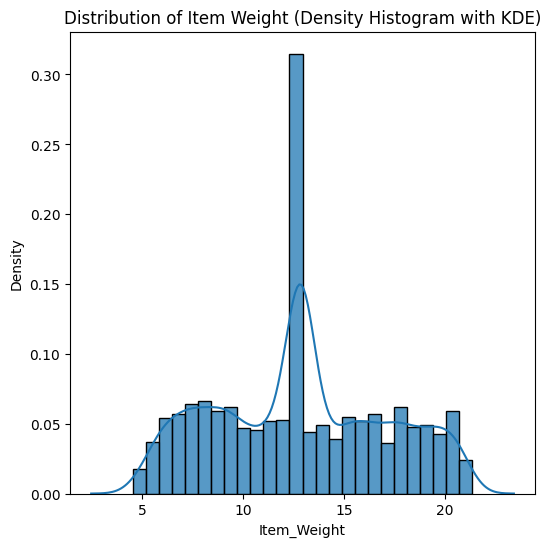

In [14]:
# Item_Weight distribution
plt.figure(figsize=(6, 6))
sns.histplot(big_mart_data['Item_Weight'], stat='density') 
sns.kdeplot(big_mart_data['Item_Weight'])
plt.title('Distribution of Item Weight (Density Histogram with KDE)')
plt.xlabel('Item_Weight')
plt.ylabel('Density')
plt.show()

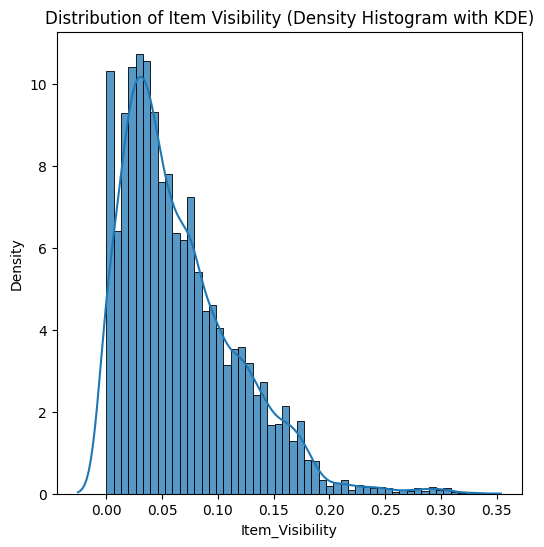

In [15]:
# Item Visibility distribution
plt.figure(figsize=(6, 6))
sns.histplot(big_mart_data['Item_Visibility'], stat='density') 
sns.kdeplot(big_mart_data['Item_Visibility'])
plt.title('Distribution of Item Visibility (Density Histogram with KDE)')
plt.xlabel('Item_Visibility')
plt.ylabel('Density')
plt.show()

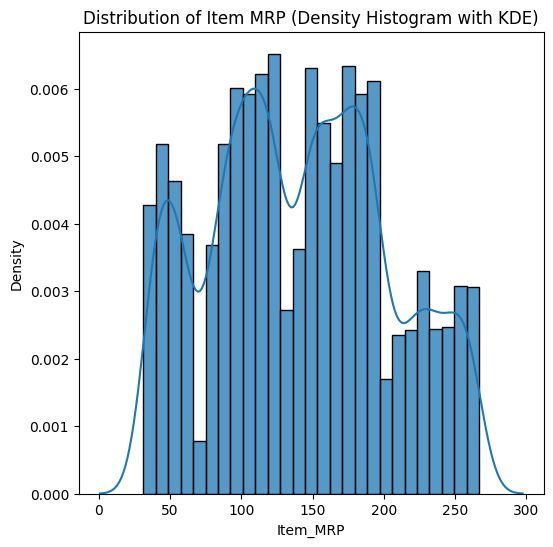

In [16]:
# Item MRP distribution
plt.figure(figsize=(6, 6))
sns.histplot(big_mart_data['Item_MRP'], stat='density') 
sns.kdeplot(big_mart_data['Item_MRP'])
plt.title('Distribution of Item MRP (Density Histogram with KDE)')
plt.xlabel('Item_MRP')
plt.ylabel('Density')
plt.show()

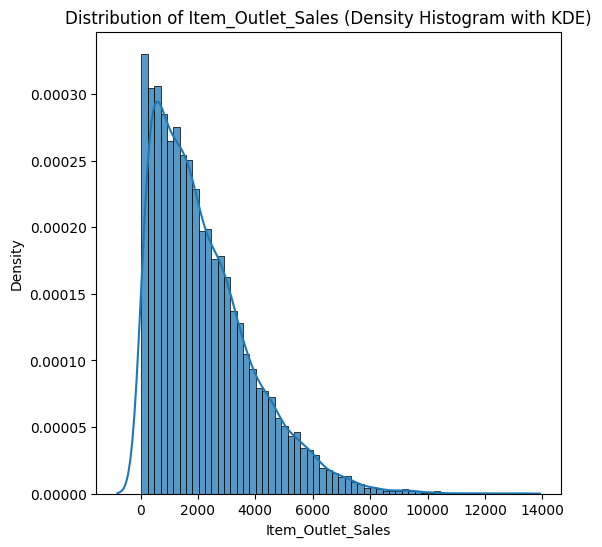

In [17]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6, 6))
sns.histplot(big_mart_data['Item_Outlet_Sales'], stat='density') 
sns.kdeplot(big_mart_data['Item_Outlet_Sales'])
plt.title('Distribution of Item_Outlet_Sales (Density Histogram with KDE)')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Density')
plt.show()

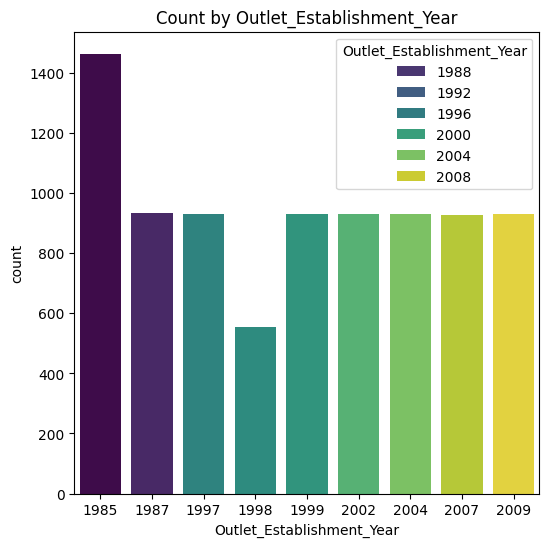

In [18]:

plt.figure(figsize=(6, 6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data, hue='Outlet_Establishment_Year', palette = 'viridis')
plt.title('Count by Outlet_Establishment_Year')
plt.show()

### Categorical Features

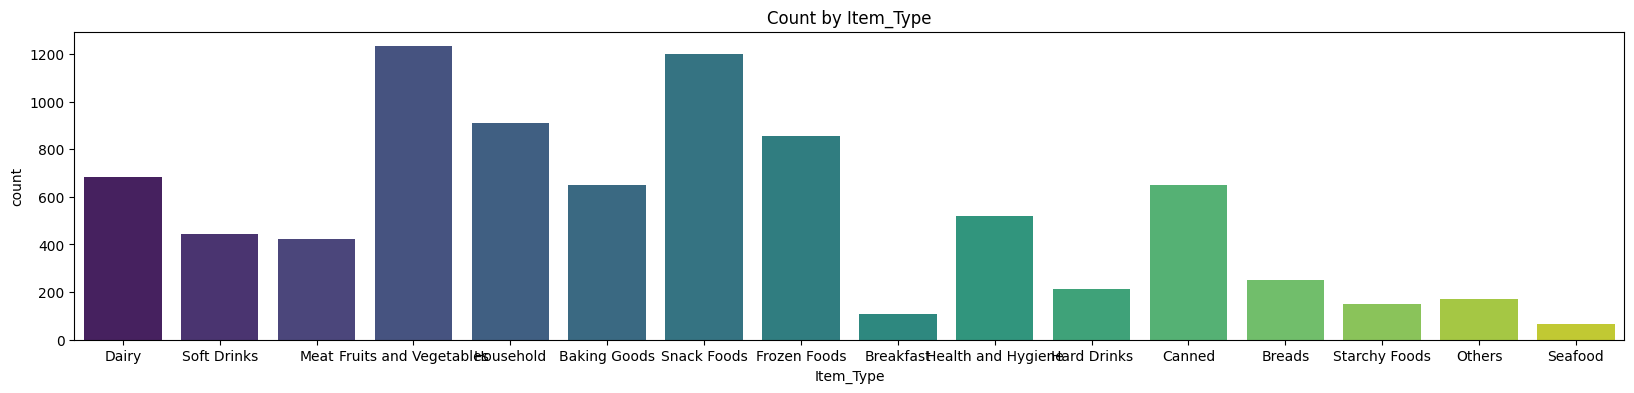

In [19]:
# Item_Type column
plt.figure(figsize=(20,4))
sns.countplot(x='Item_Type', data=big_mart_data, hue = 'Item_Type',palette = 'viridis')
plt.title('Count by Item_Type')
plt.show()

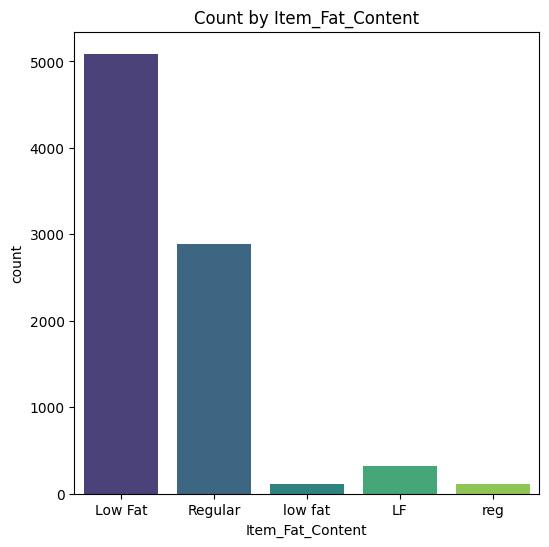

In [20]:
# Item_Fat_Content column
plt.figure(figsize=(6, 6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data, hue='Item_Fat_Content', palette = 'viridis')
plt.title('Count by Item_Fat_Content')
plt.show()

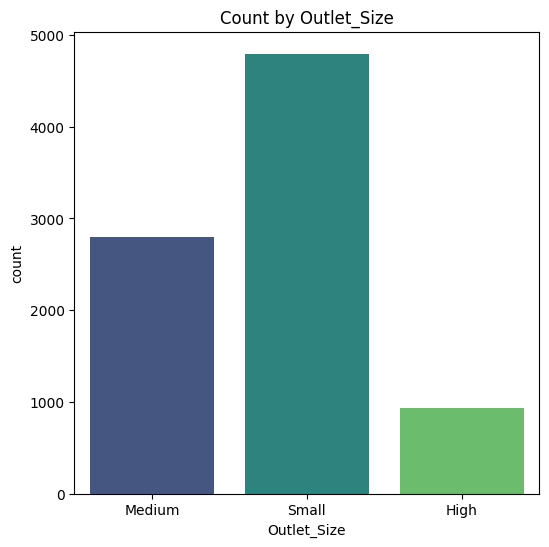

In [21]:
# Outlet_Size column
plt.figure(figsize=(6, 6))
sns.countplot(x='Outlet_Size', data=big_mart_data, hue='Outlet_Size', palette = 'viridis')
plt.title('Count by Outlet_Size')
plt.show()

## Data Preprocessing

In [22]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [23]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

## Label Encoding

In [24]:
encoder = LabelEncoder()

big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [25]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


#### Missing values have been handled, and categorical features have been encoded. The data is now ready for model training.

## Dividing Features and Target Variables

In [26]:
X = big_mart_data.iloc[:,:-1]
Y = big_mart_data['Item_Outlet_Sales']

In [27]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [28]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


## Dividing the Data into Training Data and Testing Data

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


## Machine Learning Model Training

In [31]:
regressor = XGBRegressor(n_estimators=1000,
                     learning_rate=0.05,
                     max_depth=5,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     random_state=42,
                     early_stopping_rounds=10,
                     verbose=False)

In [32]:
regressor.fit(X_train, Y_train,eval_set=[(X_test, Y_test)])

[0]	validation_0-rmse:1601.49237
[1]	validation_0-rmse:1581.61239
[2]	validation_0-rmse:1535.48837
[3]	validation_0-rmse:1519.07462
[4]	validation_0-rmse:1479.73316
[5]	validation_0-rmse:1443.82930
[6]	validation_0-rmse:1407.96325
[7]	validation_0-rmse:1376.19493
[8]	validation_0-rmse:1345.58273
[9]	validation_0-rmse:1317.49027
[10]	validation_0-rmse:1291.76932
[11]	validation_0-rmse:1268.14898
[12]	validation_0-rmse:1246.45187
[13]	validation_0-rmse:1226.78638
[14]	validation_0-rmse:1208.64732
[15]	validation_0-rmse:1191.79433
[16]	validation_0-rmse:1177.02529
[17]	validation_0-rmse:1163.41938
[18]	validation_0-rmse:1150.26060
[19]	validation_0-rmse:1138.78747
[20]	validation_0-rmse:1128.61539
[21]	validation_0-rmse:1124.49885
[22]	validation_0-rmse:1115.82628
[23]	validation_0-rmse:1107.15610
[24]	validation_0-rmse:1100.46991
[25]	validation_0-rmse:1093.77058
[26]	validation_0-rmse:1087.03889
[27]	validation_0-rmse:1084.43345
[28]	validation_0-rmse:1081.95271
[29]	validation_0-rmse:1

/home/abhinav/.local/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [13:19:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[36]	validation_0-rmse:1050.32522
[37]	validation_0-rmse:1047.44301
[38]	validation_0-rmse:1044.88013
[39]	validation_0-rmse:1042.71123
[40]	validation_0-rmse:1040.64615
[41]	validation_0-rmse:1038.60335
[42]	validation_0-rmse:1037.35708
[43]	validation_0-rmse:1035.98225
[44]	validation_0-rmse:1034.32377
[45]	validation_0-rmse:1033.34727
[46]	validation_0-rmse:1032.80261
[47]	validation_0-rmse:1032.11424
[48]	validation_0-rmse:1031.39106
[49]	validation_0-rmse:1031.15567
[50]	validation_0-rmse:1030.23221
[51]	validation_0-rmse:1029.70312
[52]	validation_0-rmse:1029.32057
[53]	validation_0-rmse:1029.09067
[54]	validation_0-rmse:1028.43147
[55]	validation_0-rmse:1028.35515
[56]	validation_0-rmse:1027.93605
[57]	validation_0-rmse:1027.70614
[58]	validation_0-rmse:1028.00855
[59]	validation_0-rmse:1027.62406
[60]	validation_0-rmse:1027.19814
[61]	validation_0-rmse:1026.91022
[62]	validation_0-rmse:1026.61317
[63]	validation_0-rmse:1026.51668
[64]	validation_0-rmse:1025.85041
[65]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Final Evaluation

In [33]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [34]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print('R Squared value = ', r2_train)

R Squared value =  0.6318774159135413


In [35]:
# prediction on training data
testing_data_prediction = regressor.predict(X_test)

In [36]:
# R squared Value
r2_test = metrics.r2_score(Y_test, testing_data_prediction)
print('R Squared value = ', r2_test)

R Squared value =  0.6140672642019055


## Conclusion
In conclusion, the XGBoost Regressor model has demonstrated a reasonable ability to predict Big Mart sales, achieving an R-squared value of approximately 0.61 on the test data. This suggests that the model captures a significant portion of the variance in sales based on the provided features.  This model provides a foundation for future improvements and more detailed sales forecasting.